1. Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.autograd import set_detect_anomaly

In [2]:
ROOT_DIR = '../content/drive/MyDrive/Colab_data/set-lipstick-original'



In [3]:
df = pd.read_csv('../content/drive/MyDrive/Colab_data/set-lipstick-original/list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


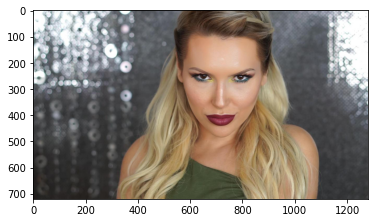

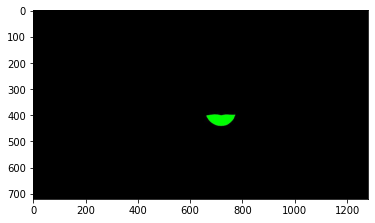

In [4]:
img = plt.imread('../content/drive/MyDrive/Colab_data/set-lipstick-original/720p/image00000001.jpg')
plt.imshow(img)
plt.show()
# Второй рисунок - трехканальное изображение - надо перевести в одноканальное (так как 1 класс)
mask = plt.imread('../content/drive/MyDrive/Colab_data/set-lipstick-original/mask/mask00000001.png')
plt.imshow(mask)
plt.show()

In [5]:
image = []
image_mask = []
for root, dirs, files in os.walk('../content/drive/MyDrive/Colab_data/set-lipstick-original'):
    for name in files:
        f = os.path.join(root, name)
        if 'image' in f:
            image.append(f)
        elif 'mask' in f:
            image_mask.append(f)
        else:
            break

In [6]:
df['filename'] = df['filename'].apply(lambda x: '../content/drive/MyDrive/Colab_data/set-lipstick-original/720p/' + x)
df['mask'] = df['mask'].apply(lambda x: '../content/drive/MyDrive/Colab_data/set-lipstick-original/mask/' + x)
df = df[df['filename'].isin(image)] 
df = df[df['mask'].isin(image_mask)]

In [7]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,8]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (H, W, 3) -> (1, H, W, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, H, W, 3) -> (1, 3, H, W)
        img = img.unsqueeze(0).permute(0,3,1,2)

        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с HхW на 256х256
        # clamp не позволяет выйти за границы
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic').clamp(min=0, max=1)
        
        # Читаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        mask = Image.open(self.label_arr[index]).convert('LA') # преобразование в серый
        mask = np.asarray(mask).astype('float')[:,:,0]
        mask = torch.as_tensor(np.where(mask > 100, 1.0, 0)).unsqueeze(0) # введение порога и нормализация
        mask = mask.unsqueeze(0)
        mask = mask.float()
        # делаем ресайз картинки на 256х256
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

In [8]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [9]:
train_data_loader = DataLoader(train_data,batch_size=1,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=16,shuffle=False)

2.	И затем обучить Модель на выбор из segmentation_models_pytorch


In [10]:
import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

In [11]:

learning_rate = 0.001
epochs = 1

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [13]:
# Создание своей модели
Umodel = UNet(num_classes=1).to(device)

In [15]:
import segmentation_models_pytorch as smp

# Создание модели из segmentation_models_pytorch
Umodel = smp.Unet('mobilenet_v2', 
                  classes=1, 
                  encoder_weights='imagenet').to(device)

In [16]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)


In [17]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

In [18]:
criterion = SoftDiceLoss()


In [19]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

1 epochs, 19978 total_steps per epoch


Train Epoch: 1, Loss: 0.40501299142837527
Spend time for 300 images: 292.3045847415924 sec


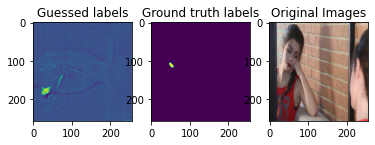

Train Epoch: 1, Loss: 0.12366714795430502
Spend time for 300 images: 275.55955386161804 sec


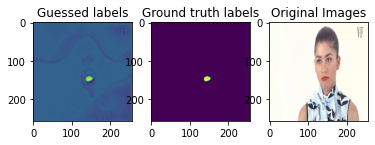

Train Epoch: 1, Loss: 0.11665722727775574
Spend time for 300 images: 267.54131603240967 sec


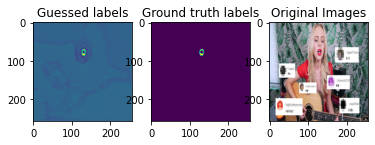

Train Epoch: 1, Loss: 0.0974384601910909
Spend time for 300 images: 267.2417006492615 sec


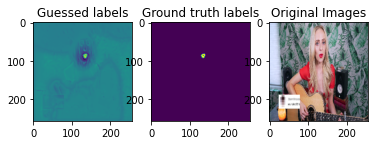

Train Epoch: 1, Loss: 0.08960318903128306
Spend time for 300 images: 265.3729600906372 sec


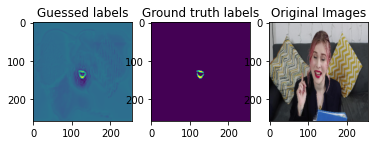

Train Epoch: 1, Loss: 0.06772393981615703
Spend time for 300 images: 257.15986227989197 sec


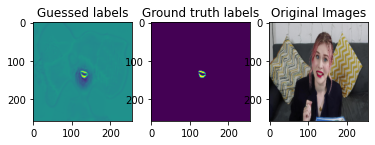

Train Epoch: 1, Loss: 0.07780090947945913
Spend time for 300 images: 253.28334760665894 sec


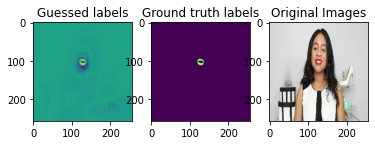

Train Epoch: 1, Loss: 0.09228539288043976
Spend time for 300 images: 255.51796221733093 sec


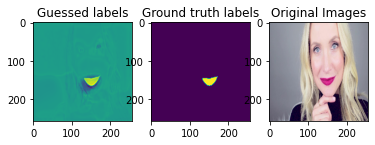

Train Epoch: 1, Loss: 0.06599189579486847
Spend time for 300 images: 254.99960112571716 sec


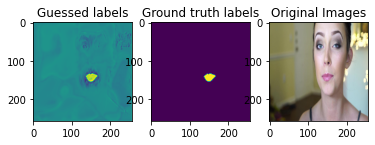

Train Epoch: 1, Loss: 0.07428981701533
Spend time for 300 images: 250.82644414901733 sec


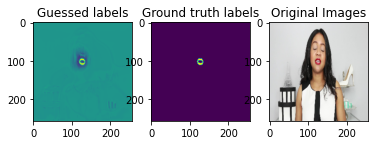

Train Epoch: 1, Loss: 0.06513457576433818
Spend time for 300 images: 251.84757828712463 sec


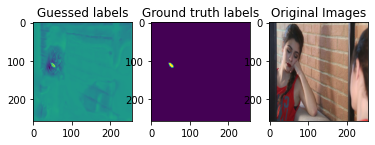

Train Epoch: 1, Loss: 0.06321910202503205
Spend time for 300 images: 247.99260354042053 sec


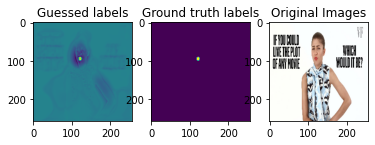

Train Epoch: 1, Loss: 0.05315207282702128
Spend time for 300 images: 250.81755256652832 sec


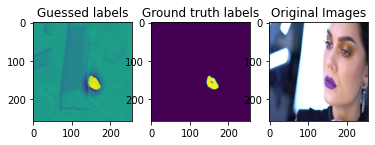

Train Epoch: 1, Loss: 0.05528512398401896
Spend time for 300 images: 248.1683394908905 sec


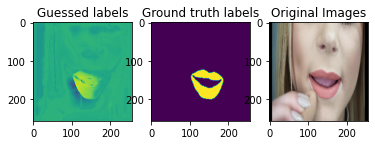

Train Epoch: 1, Loss: 0.05739392201105754
Spend time for 300 images: 253.7842984199524 sec


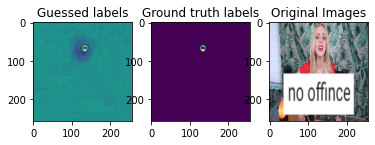

Train Epoch: 1, Loss: 0.051065468192100526
Spend time for 300 images: 249.62030267715454 sec


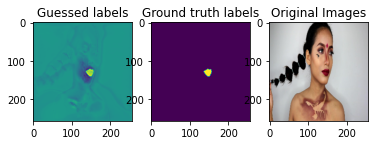

Train Epoch: 1, Loss: 0.04825154602527618
Spend time for 300 images: 246.90175199508667 sec


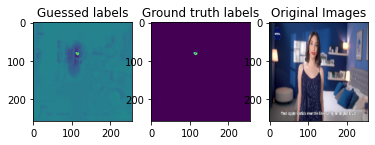

Train Epoch: 1, Loss: 0.044909722208976745
Spend time for 300 images: 251.49992895126343 sec


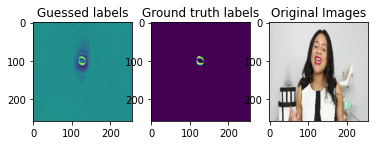

Train Epoch: 1, Loss: 0.042746634284655256
Spend time for 300 images: 245.67995309829712 sec


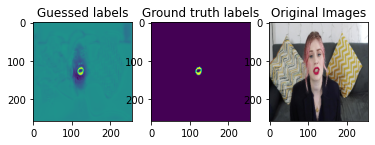

Train Epoch: 1, Loss: 0.06633359889189402
Spend time for 300 images: 244.51815104484558 sec


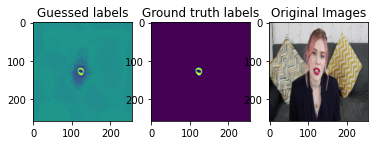

Train Epoch: 1, Loss: 0.04836469848950704
Spend time for 300 images: 243.9600830078125 sec


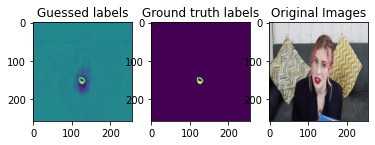

Train Epoch: 1, Loss: 0.05081753412882487
Spend time for 300 images: 244.7300705909729 sec


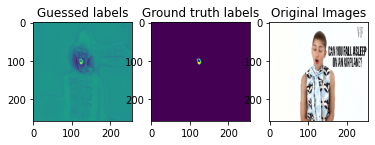

Train Epoch: 1, Loss: 0.06032694141070048
Spend time for 300 images: 247.17389369010925 sec


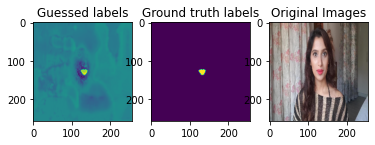

Train Epoch: 1, Loss: 0.047726688782374065
Spend time for 300 images: 244.77609157562256 sec


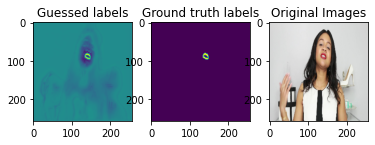

Train Epoch: 1, Loss: 0.05067805965741475
Spend time for 300 images: 241.03540134429932 sec


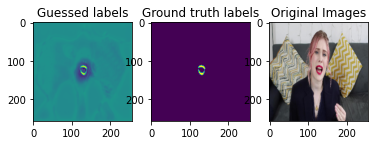

Train Epoch: 1, Loss: 0.06181922475496928
Spend time for 300 images: 245.13998317718506 sec


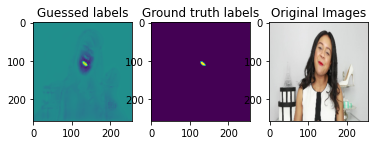

Train Epoch: 1, Loss: 0.054768816232681275
Spend time for 300 images: 243.16030311584473 sec


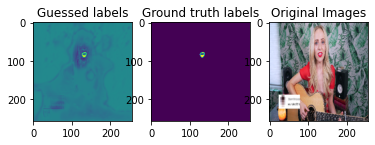

Train Epoch: 1, Loss: 0.057601369818051654
Spend time for 300 images: 240.24679160118103 sec


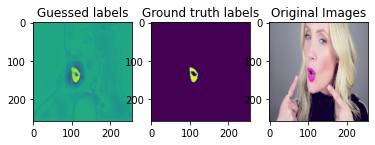

Train Epoch: 1, Loss: 0.04619730830192566
Spend time for 300 images: 241.7052924633026 sec


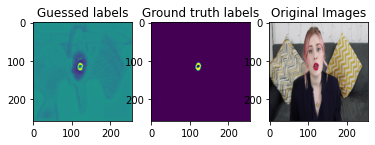

Train Epoch: 1, Loss: 0.05080654561519623
Spend time for 300 images: 244.05637288093567 sec


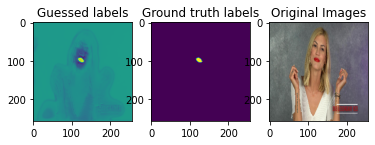

Train Epoch: 1, Loss: 0.045391428073247274
Spend time for 300 images: 242.54284524917603 sec


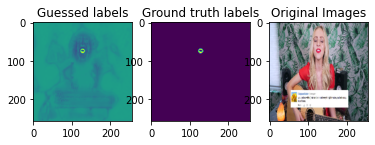

Train Epoch: 1, Loss: 0.04577340642611186
Spend time for 300 images: 243.12742733955383 sec


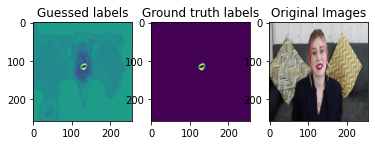

Train Epoch: 1, Loss: 0.04415958921114604
Spend time for 300 images: 242.4693467617035 sec


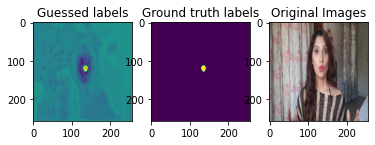

Train Epoch: 1, Loss: 0.045184807976086934
Spend time for 300 images: 247.46525835990906 sec


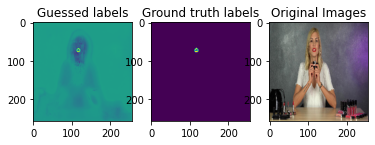

Train Epoch: 1, Loss: 0.04946433881918589
Spend time for 300 images: 241.30882334709167 sec


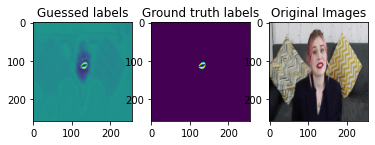

Train Epoch: 1, Loss: 0.05010303159554799
Spend time for 300 images: 243.83573150634766 sec


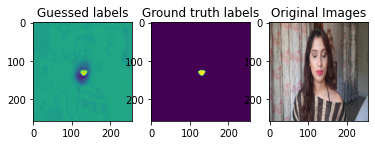

Train Epoch: 1, Loss: 0.05454048871994019
Spend time for 300 images: 241.17091965675354 sec


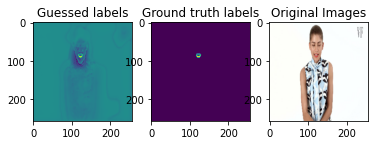

Train Epoch: 1, Loss: 0.047635120352109275
Spend time for 300 images: 241.50966596603394 sec


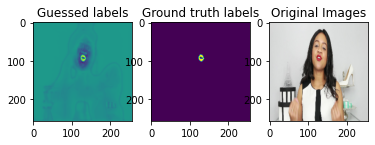

Train Epoch: 1, Loss: 0.042290351192156475
Spend time for 300 images: 238.28670620918274 sec


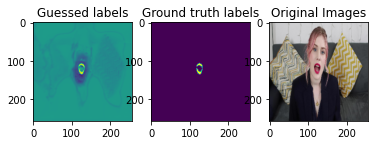

Train Epoch: 1, Loss: 0.04347720980644226
Spend time for 300 images: 237.89384293556213 sec


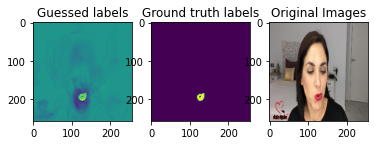

Train Epoch: 1, Loss: 0.04311477303504944
Spend time for 300 images: 243.59740018844604 sec


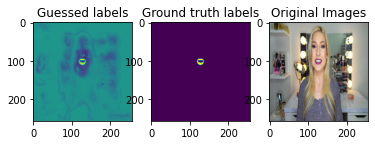

Train Epoch: 1, Loss: 0.0470786851644516
Spend time for 300 images: 238.78569841384888 sec


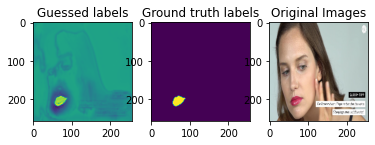

Train Epoch: 1, Loss: 0.04508970717589061
Spend time for 300 images: 240.6715841293335 sec


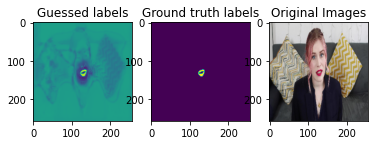

Train Epoch: 1, Loss: 0.051213485399882
Spend time for 300 images: 243.86521816253662 sec


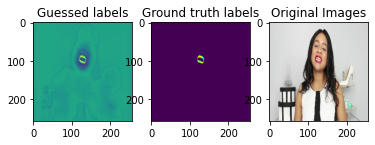

Train Epoch: 1, Loss: 0.0479053791364034
Spend time for 300 images: 247.68583798408508 sec


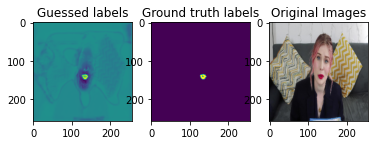

Train Epoch: 1, Loss: 0.04155485967795054
Spend time for 300 images: 240.46543955802917 sec


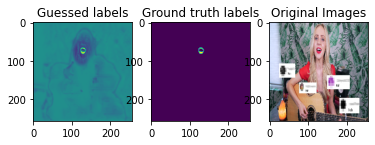

Train Epoch: 1, Loss: 0.049721906979878744
Spend time for 300 images: 243.62745785713196 sec


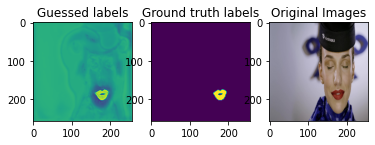

Train Epoch: 1, Loss: 0.0452747505903244
Spend time for 300 images: 239.02461409568787 sec


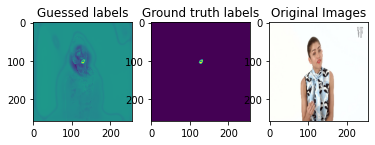

Train Epoch: 1, Loss: 0.041952844659487405
Spend time for 300 images: 250.7379331588745 sec


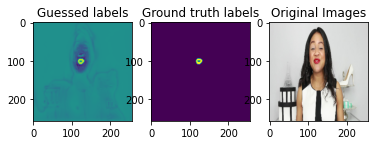

Train Epoch: 1, Loss: 0.04621704796950022
Spend time for 300 images: 250.17974042892456 sec


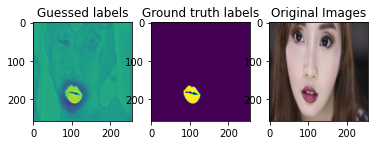

Train Epoch: 1, Loss: 0.0805025964975357
Spend time for 300 images: 246.3299469947815 sec


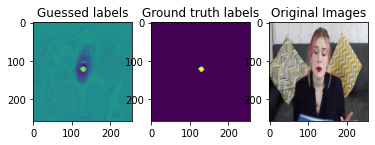

Train Epoch: 1, Loss: 0.04702937304973602
Spend time for 300 images: 240.4403350353241 sec


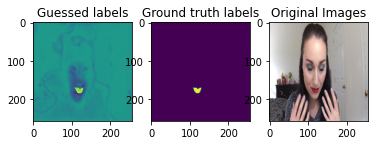

Train Epoch: 1, Loss: 0.043248018622398375
Spend time for 300 images: 244.42612147331238 sec


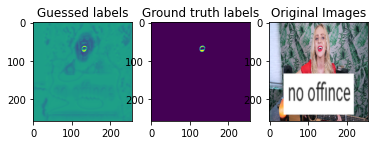

Train Epoch: 1, Loss: 0.04293962836265564
Spend time for 300 images: 240.47419714927673 sec


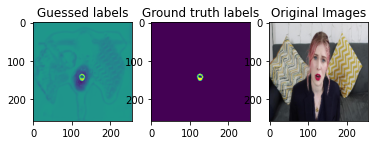

Train Epoch: 1, Loss: 0.04517676115036011
Spend time for 300 images: 240.82656812667847 sec


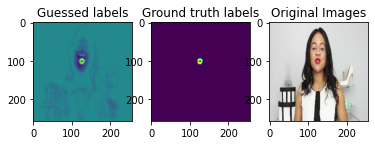

Train Epoch: 1, Loss: 0.04423807382583618
Spend time for 300 images: 238.46409344673157 sec


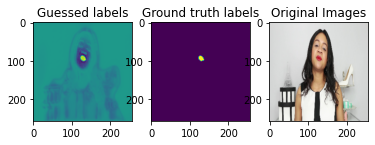

Train Epoch: 1, Loss: 0.039012518326441446
Spend time for 300 images: 238.43635892868042 sec


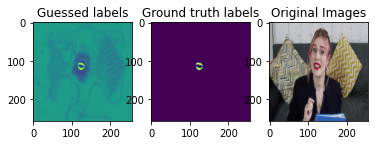

Train Epoch: 1, Loss: 0.03896422127882639
Spend time for 300 images: 239.8895218372345 sec


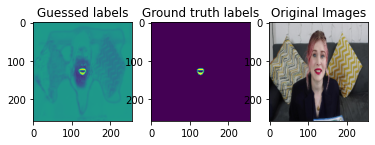

Train Epoch: 1, Loss: 0.041805484493573505
Spend time for 300 images: 240.04111409187317 sec


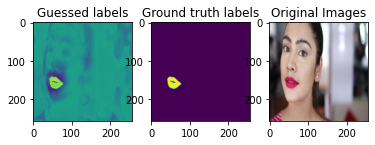

Train Epoch: 1, Loss: 0.03816183845202128
Spend time for 300 images: 240.40135550498962 sec


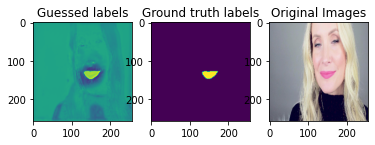

Train Epoch: 1, Loss: 0.03886001249154409
Spend time for 300 images: 238.46956133842468 sec


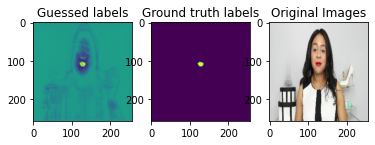

Train Epoch: 1, Loss: 0.03944342573483785
Spend time for 300 images: 237.496595621109 sec


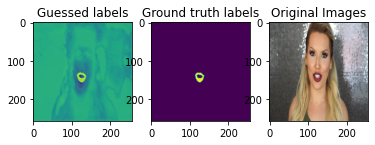

Train Epoch: 1, Loss: 0.045757795174916585
Spend time for 300 images: 239.68808770179749 sec


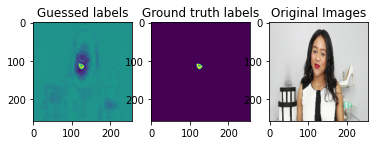

Train Epoch: 1, Loss: 0.0416092570622762
Spend time for 300 images: 239.36053657531738 sec


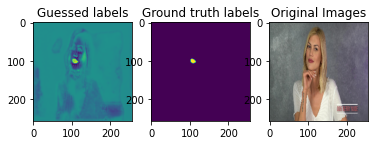

Train Epoch: 1, Loss: 0.0442196383078893
Spend time for 300 images: 236.21984219551086 sec


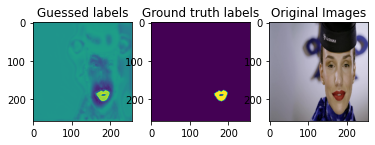

Train Epoch: 1, Loss: 0.03773394783337911
Spend time for 300 images: 236.16056632995605 sec


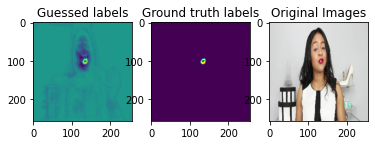

Epoch 1, loss:  0.05924626303537792


In [20]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(epochs):
    
    time1 = time.time()
    running_loss =0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_data_loader):
        
        data, labels = Variable(data), Variable(labels)        
        data = data.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()
        
        outputs = Umodel(data[0])

        loss = criterion(outputs, labels[0])
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 300 == 299:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/300}')
            time2 = time.time()
            print(f'Spend time for 300 images: {time2-time1} sec')
            time1 = time.time()
            running_loss = 0.0

            f, axarr = plt.subplots(1,3)
            #axarr[0].imshow(torch.argmax(outputs.detach().cpu().numpy()[0,:,:]))
            axarr[0].imshow(outputs.detach().cpu().numpy()[0, 0, :,:])
            axarr[0].set_title('Guessed labels')

            axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
            axarr[1].set_title('Ground truth labels')

            axarr[2].imshow(data[0].permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:])
            axarr[2].set_title('Original Images')
            plt.show()

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)